# Previsão da Audiência de Website de Notícias
Sumário
1. Descrição do problema
2. Análise exploratória
3. Pré-processamento
4. Análise dos dados
5. Previsão de pageviews
6. Conclusão

# 1. Descrição do problema

Para entender o comportamento da audiência em seu website, uma empresa de notícias pode acompanhar algumas métricas: pageviews, usuários e sessões. Um usuário pode acessar uma página e consumir os conteúdos do site. Cada página que o usuário abre, corresponde a um pageview e cada vez que ele navega em um conjunto de páginas, corresponde a uma sessão.

O dataset analisado possui 834.810 linhas, com dados de 01/01/21 a 03/05/21 e as seguites colunas:
- date: Data de observação da audiência.

- hits_hour: Horário de observação da audiência (hits_hour = 10 inclui 10:00h até 10:59h).

- geoNetwork_region: Unidade da Federação (Estado).

- device_deviceCategory: Dispositivo utilizado.

- editoria: Agrupamento de matérias por assunto.

- trafficSource_medium: A mídia da origem de tráfego.

- trafficSource_source: A origem do tráfego.

- variable: Tipo de métrica (pageviews, usuários ou sessões).

- value: Valor da métrica.

# 2. Análise exploratória

Será realizada uma análise exploratória para compreender a natureza dos dados e identificar problemas (dados faltantes/inconsistentes).

In [1]:
# importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.interpolate import make_interp_spline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools

# leitura do arquivo com os dados
df = pd.read_csv('/kaggle/input/dados-desafio/dados_desafio.csv')

In [2]:
# visualização das primeiras linhas do dataset
df.head()

,date,hits_hour,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,variable,value
0,20210101,0,Federal District,mobile,editoria_01,(none),(direct),usuarios,14
1,20210101,0,Federal District,mobile,editoria_01,(none),(direct),sessoes,15
2,20210101,0,Federal District,mobile,editoria_01,(none),(direct),pageviews,18
3,20210101,0,Federal District,mobile,editoria_01,organic,google,usuarios,14
4,20210101,0,Federal District,mobile,editoria_01,organic,google,sessoes,15


In [3]:
# visualização dos data types e da contagem de não nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834810 entries, 0 to 834809
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   date                   834810 non-null  object
 1   hits_hour              834810 non-null  int64 
 2   geoNetwork_region      834810 non-null  object
 3   device_deviceCategory  834810 non-null  object
 4   editoria               834810 non-null  object
 5   trafficSource_medium   834810 non-null  object
 6   trafficSource_source   834810 non-null  object
 7   variable               834810 non-null  object
 8   value                  834810 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 57.3+ MB


In [4]:
# descrição das tendências das variáveis numéricas
df.describe()

,hits_hour,value
count,834810.000000,834810.000000
mean,14.209161,48.669215
std,5.851890,99.944381
min,0.000000,1.000000
25%,10.000000,16.000000
50%,15.000000,24.000000
75%,19.000000,46.000000
max,23.000000,8048.000000


In [5]:
# visualização da contagem dos valores das variáveis
for i in df.columns:
    print('\n')
    print(df[[i]].value_counts())



date       
20210117       12546
20210402       10335
20210314       10212
20210120        9954
20210123        9909
               ...  
16-jan-2021        3
31-mar-2021        3
01-fev-2021        3
01-abr-2021        3
25-abr-2021        2
Length: 516, dtype: int64


hits_hour
20           53138
21           52258
19           51336
18           49101
16           47788
22           47593
17           47395
13           47034
14           46666
15           46634
12           43877
11           41715
10           38873
9            37214
8            35526
23           35070
7            31328
0            22699
6            22031
1            11442
5            10546
2             6267
4             5037
3             4242
dtype: int64


geoNetwork_region           
State of Sao Paulo              226612
State of Rio de Janeiro          92478
State of Minas Gerais            82599
State of Parana                  53285
State of Rio Grande do Sul       50956
State of Bahia        

As datas estão em diversos formatos diferentes. Algumas editorias estão com pequenos erros no nome. Isto será tratado no pré-processamento.

# 3. Pré-processamento

In [6]:
# formatação das datas

# substituição do mês pela forma numérica
df['date'] = df['date'].str.replace('jan', '01')
df['date'] = df['date'].str.replace('fev', '02')
df['date'] = df['date'].str.replace('mar', '03')
df['date'] = df['date'].str.replace('abr', '04')
df['date'] = df['date'].str.replace('mai', '05')

# substituição de - por /
df['date'] = df['date'].str.replace('-', '/')

# substituição de 21 por 2021 nas datas que começam com o ano
df['date'] = df['date'].str.replace(r'^21(/\d\d/\d\d)$', r'2021\1', regex = True)

# substituição de 21 por 2021 nas datas que terminam com o ano
df['date'] = df['date'].str.replace(r'^(\d\d/\d\d/)21$', r'\g<1>2021', regex = True)

# inversão das datas de dd/mm/yyyy para yyyy/mm/dd
df['date'] = df['date'].str.replace(r'^(\d\d)/(\d\d)/2021', r'2021/\2/\1', regex = True)

# remoção da /
df['date'] = df['date'].str.replace('/', '')

In [7]:
# conversão do tipo da data para datetime64
df['date'] = pd.to_datetime(df.date)

# visualização das datas
df['date'].value_counts()

2021-01-17    12864
2021-03-14    11112
2021-04-02    11010
2021-03-05    10404
2021-01-23    10176
              ...  
2021-02-09     3609
2021-02-06     3582
2021-04-24     3548
2021-04-25     3392
2021-02-05     3180
Name: date, Length: 123, dtype: int64

In [8]:
# correção das editorias
df['editoria'] = df['editoria'].str.replace('editeria_01', 'editoria_01')
df['editoria'] = df['editoria'].str.replace('editoria_07 ', 'editoria_07')
df['editoria'] = df['editoria'].str.replace('Editoria_05', 'editoria_05')
df['editoria'] = df['editoria'].str.replace('editoria 11', 'editoria_11')

In [9]:
# a variável hits_hour não é relevante porque vamos analisar o total de pageviews do dia

# remoção da coluna hits_hour
df_sem_hit = df.drop('hits_hour', 1)

In [10]:
# separação de pageviews, usuários e sessões

# filtro de pageviews na coluna variable
df_pag = df_sem_hit[(df_sem_hit['variable'] == 'pageviews')]
# exclusão da coluna variable
df_pag = df_pag.drop('variable', 1)
# alteração do nome da coluna value
df_pag = df_pag.rename(columns = {'value': 'value_pag'})

# filtro de usuários na coluna variable
df_usu = df_sem_hit[(df_sem_hit['variable'] == 'usuarios')]
# exclusão da coluna variable
df_usu = df_usu.drop('variable', 1)
# alteração do nome da coluna value
df_usu = df_usu.rename(columns = {'value': 'value_usu'})

# filtro de sessões na coluna variable
df_ses = df_sem_hit[(df_sem_hit['variable'] == 'sessoes')]
# exclusão da coluna variable
df_ses = df_ses.drop('variable', 1)
# alteração do nome da coluna value
df_ses = df_ses.rename(columns = {'value': 'value_ses'})

In [11]:
# agrupamento das linhas, somando value

df_pag = df_pag.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_pag': 'sum'}).reset_index()

df_usu = df_usu.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_usu': 'sum'}).reset_index()

df_ses = df_ses.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_ses': 'sum'}).reset_index()

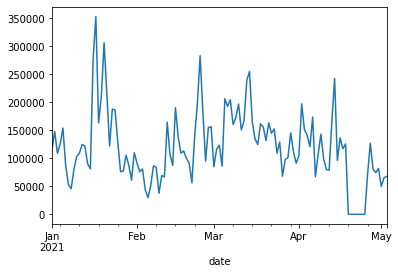

In [12]:
# visualização do número de pageviews por dia
df_pag_d = df_pag.set_index('date')
df_pag_d = df_pag_d['value_pag'].resample('D').sum()
df_pag_d.plot();

Existe um intervalo em abril onde o número de pageviews foi zero. Será necessário realizar o tratamento desses missings.

In [13]:
# faremos o tratamento de missings de pageviews usando como base o valor de sessões ou de usuários

# união de df_pag, df_usu e df_ses

df_metricas_separadas = pd.merge(
    df_usu,
    df_ses,
    how = 'outer',
    on = ['date', 'geoNetwork_region', 'device_deviceCategory', 'editoria', 'trafficSource_medium', 'trafficSource_source'])

df_metricas_separadas = pd.merge(
    df_metricas_separadas,
    df_pag,how = 'outer',
    on = ['date', 'geoNetwork_region', 'device_deviceCategory', 'editoria', 'trafficSource_medium', 'trafficSource_source'])

# visualização das primeiras linhas
df_metricas_separadas.head()

,date,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,value_usu,value_ses,value_pag
0,2021-01-01,Federal District,desktop,editoria_11,organic,google,1,1,14.0
1,2021-01-01,Federal District,desktop,editoria_12,organic,google,1,1,14.0
2,2021-01-01,Federal District,mobile,editoria_01,(none),(direct),820,833,996.0
3,2021-01-01,Federal District,mobile,editoria_01,organic,google,725,729,870.0
4,2021-01-01,Federal District,mobile,editoria_01,referral,googleapis.com,380,380,465.0


In [14]:
# correlação entre pageviews, sessões e usuários
df_metricas_separadas.corr().style.format('{:,.3f}')

,value_usu,value_ses,value_pag
value_usu,1.000,0.890,0.999
value_ses,0.890,1.000,0.887
value_pag,0.999,0.887,1.000


A correlação de pageviews com usuários é maior do que a de pageviews com sessões. O valor de usuários será utilizado como base para preencher os missings de pageviews.

In [15]:
# cálculo da relação entre a média de pageviews e de usuários
coef = df_metricas_separadas['value_pag'].mean() / df_metricas_separadas['value_usu'].mean()
coef

1.2541930385740836

In [16]:
# substituição dos missings por value_usu multiplicado pelo coeficiente calculado
df_metricas_separadas['value_pag'].fillna(df_metricas_separadas['value_usu'] * coef, inplace = True)

# transformação de value_pag em integer
df_metricas_separadas['value_pag'] = df_metricas_separadas['value_pag'].astype(int)

In [17]:
# remoção das colunas value_ses e value_usu
df_tratado = df_metricas_separadas.drop(['value_ses', 'value_usu'], 1)

# visualização das primeiras linhas do dataset tratado
df_tratado.head()

,date,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,value_pag
0,2021-01-01,Federal District,desktop,editoria_11,organic,google,14
1,2021-01-01,Federal District,desktop,editoria_12,organic,google,14
2,2021-01-01,Federal District,mobile,editoria_01,(none),(direct),996
3,2021-01-01,Federal District,mobile,editoria_01,organic,google,870
4,2021-01-01,Federal District,mobile,editoria_01,referral,googleapis.com,465


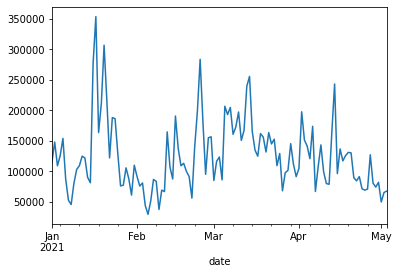

In [18]:
# visualização do número de pageviews por dia após o tratamento de missings
df_tratado_d = df_tratado.set_index('date')
df_tratado_d = df_tratado_d['value_pag'].resample('D').sum()
df_tratado_d.plot();

É possível perceber uma tendência de queda na audiência do website. Será realizada uma análise do que pode estar causando essa queda.

# 4. Análise dos dados

Para obter o número médio de pageviews por dia, o total de pageviews do mês será dividido pelo número de dias daquele mês.

In [19]:
# criação de uma coluna de mês
df_tratado['mes'] = df_tratado['date'].dt.month

# criação de uma lista com a quantidade de dias de cada mês
n_dias = [31, 28, 31, 30, 3]

In [20]:
# visualização do número médio de pageviews por dia de cada mês para a variável geoNetwork_region

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'geoNetwork_region',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

pd.set_option('display.max_columns', None)
df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 56172)

geoNetwork_region,Federal District,State of Acre,State of Alagoas,State of Amapa,State of Amazonas,State of Bahia,State of Ceara,State of Espirito Santo,State of Goias,State of Maranhao,State of Mato Grosso,State of Mato Grosso do Sul,State of Minas Gerais,State of Para,State of Paraiba,State of Parana,State of Pernambuco,State of Piaui,State of Rio Grande do Norte,State of Rio Grande do Sul,State of Rio de Janeiro,State of Rondonia,State of Roraima,State of Santa Catarina,State of Sao Paulo,State of Sergipe,State of Tocantins
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"3,019",0,293,48,"1,405","5,987","2,716","1,943","2,553",939,846,"1,263","15,362","1,591",637,"7,775","3,269",362,"1,057","7,411","17,346",140,6,"4,560","55,309",195,86
2,"2,554",0,235,22,673,"5,889","2,298","1,500","2,048",913,882,902,"11,943","1,261",518,"6,040","2,836",262,756,"5,689","12,468",88,0,"3,672","46,511",152,80
3,"3,476",1,422,15,705,"7,443","3,635","2,014","3,003","1,429","1,094","1,271","15,674","2,016",870,"8,873","4,155",527,"1,293","10,100","16,874",137,1,"5,061","56,172",258,156
4,"2,898",3,419,20,568,"5,493","2,943","1,712","2,289","1,126",850,"1,076","12,756","1,642",630,"6,410","3,485",500,996,"6,327","14,187",115,2,"3,714","44,522",216,127
5,"1,313",0,92,0,146,"3,468","1,607",720,"1,084",433,306,516,"7,557","1,332",180,"3,528","1,749",208,344,"3,113","7,260",10,0,"1,908","24,051",31,18


In [21]:
# visualização do número médio de pageviews por dia de cada mês para a variável device_deviceCategory

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'device_deviceCategory',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 141617)

device_deviceCategory,desktop,mobile,tablet
mes,,,
1,"2,185","133,826",105
2,"2,952","107,034",206
3,"4,773","141,617",286
4,"4,945","109,866",213
5,"2,682","57,997",294


In [22]:
# visualização do número médio de pageviews por dia de cada mês para a variável editoria

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'editoria',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 66550)

editoria,editoria_01,editoria_02,editoria_03,editoria_04,editoria_05,editoria_06,editoria_07,editoria_08,editoria_09,editoria_10,editoria_11,editoria_12,editoria_13,editoria_14,editoria_15,editoria_16,editoria_17,editoria_18,editoria_19,editoria_20,editoria_21,editoria_22,editoria_23,editoria_24,editoria_25,editoria_26,editoria_27,editoria_28,editoria_29,editoria_30,editoria_31,editoria_32,editoria_33,editoria_34,editoria_35,editoria_36,editoria_37,editoria_38,editoria_39
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"66,550","12,670","12,553","10,751","2,425","4,152","9,191","3,545","1,722","1,271",632,628,"3,010",790,60,836,150,365,160,"1,655",680,493,596,783,0,3,19,56,80,29,18,33,81,73,6,4,26,0,19
2,"33,781","28,683","15,186","11,997","1,741","2,243","4,558","2,967","1,844",660,"1,182","1,150",596,263,425,"1,611",212,175,114,78,296,2,0,2,0,24,30,53,24,58,1,30,26,23,40,104,13,0,0
3,"49,351","35,326","12,077","4,045","5,674","5,945","5,064","6,613","2,249","4,285","1,809","1,748","1,396","4,727","2,339",217,395,"1,169","1,283",162,14,435,0,43,0,38,13,98,8,26,8,38,0,12,57,0,12,0,1
4,"24,512","40,713","5,528","6,319","17,424","4,488","2,635","3,086","2,070","2,114","1,511","1,474","1,134",48,495,0,156,30,190,60,74,0,0,28,0,355,137,0,89,17,147,16,0,2,0,0,23,79,69
5,93,"20,260","2,313","8,801","5,200","6,519","3,875",406,"1,331","1,464","1,632","1,617",28,587,431,0,170,72,10,19,0,0,0,0,"6,091",17,0,15,0,16,0,0,6,0,0,0,0,0,0


A editoria_01 foi a que teve mais pageviews no primeiro trimestre, mas sofreu uma queda e praticamente não teve pageviews em maio.

In [23]:
# visualização do número médio de pageviews por dia de cada mês para a variável trafficSource_medium

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'trafficSource_medium',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 89488)

trafficSource_medium,(none),(not set),cpc,feed,organic,pushnotification,referral,social
mes,,,,,,,,
1,"63,917",353,0,0,"41,746",220,"29,604",277
2,"61,184",476,0,0,"34,694",257,"13,284",297
3,"89,488",780,1,5,"44,599",505,"11,272",25
4,"71,621",622,0,20,"33,585",291,"8,878",8
5,"39,515",558,14,0,"18,507",141,"2,238",0


In [24]:
# visualização do número médio de pageviews por dia de cada mês para a variável trafficSource_source

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'trafficSource_source',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 89488)

trafficSource_source,(direct),bing,facebook,google,googleapis.com,instagram,news.google.com,paywall,pushnews,taboola,twitter,whatsapp,yahoo
mes,,,,,,,,,,,,,
1,"63,917",27,"8,930","41,715","19,396",0,780,325,220,126,645,28,8
2,"61,184",25,"6,918","34,669","5,526",33,811,445,258,26,254,31,12
3,"89,488",41,"8,492","44,557",783,30,"1,329",767,508,33,629,10,9
4,"71,621",43,"6,798","33,541",230,54,997,610,291,20,791,12,16
5,"39,515",57,"2,155","18,464",0,12,34,558,141,9,28,0,0


A editoria_01 será analisada separadamente.

In [25]:
# criação de um df com as colunas de mês, editoria e pageviews
df_ed = df_tratado[['mes', 'editoria', 'value_pag']]

# filtro de editoria_01
df_ed1 = df_ed[(df_ed['editoria'] == 'editoria_01')]

# agrupamento das linhas por mês, somando value
df_ed1 = df_ed1.groupby(['mes']).agg({'value_pag': 'sum'}).reset_index()

# cálculo da média diária
for i in range(5):
    df_ed1.loc[[i], ['value_pag']] = df_ed1.loc[[i], ['value_pag']] / n_dias[i]

# df com a média de pageviews por dia para cada mês da editoria_01
df_ed1.style.format('{:,.0f}').hide_index()

mes,value_pag
1,"66,550"
2,"33,781"
3,"49,351"
4,"24,512"
5,93


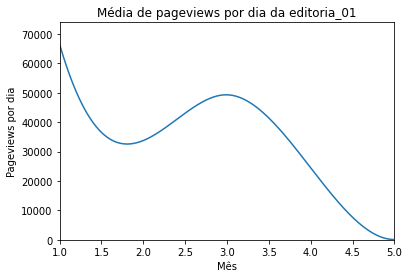

In [26]:
# visualização da média de pageviews por dia para cada mês da editoria_01
x_y_Spline = make_interp_spline(df_ed1['mes'], df_ed1['value_pag'])
x_ = np.linspace(1, 5, 200)
y_ = x_y_Spline(x_)
plt.plot(x_, y_)
plt.axis([1, 5, 0, 74000])
plt.ylabel('Pageviews por dia')
plt.xlabel('Mês')
plt.title('Média de pageviews por dia da editoria_01')
plt.show()

Examinando todos os dados, foi concluído que a provável causa da queda de pageviews foi a queda na editoria_01.

# 5. Previsão de pageviews

Para a previsão do total de pageviews para os próximos 30 dias, será utilizado o software criado pelo Facebook, Prophet. O Prophet realiza previsões ajustando tendências não lineares à sazonalidades que podem ser modificadas. O input é sempre um dataframe com duas colunas: ds e y. A coluna ds é a data e a coluna y representa a medida que será prevista.

A previsão será avaliada utilizando validação cruzada, tendo como métrica a raiz quadrada do erro médio (rmse).

In [27]:
# criação de um df com pageviews por dia para realizar a previsão
df_tratado_prev = df_tratado.groupby(['date']).agg({'value_pag': "sum"}).reset_index()

# alteração dos nomes das colunas
df_tratado_prev = df_tratado_prev.rename(columns = {"date": "ds", "value_pag": "y"})

# visualização das últimas linhas
format_dict = {'ds': '{:%Y-%m-%d}', 'y': '{:,}'}
df_tratado_prev.tail().style.format(format_dict)

,ds,y
118,2021-04-29,"74,261"
119,2021-04-30,"82,038"
120,2021-05-01,"49,860"
121,2021-05-02,"65,371"
122,2021-05-03,"67,687"


In [28]:
# tratamento de outliers

outlier_indices = []
# quartil 1
Q1 = np.percentile(df_tratado_prev['y'],25)
# quartil 3
Q3 = np.percentile(df_tratado_prev['y'],75)
# IQR
IQR = Q3 - Q1
# outlier step
outlier_step = IQR * 1.5
# detecta o outlier e seu index
outlier_list_col = df_tratado_prev[(df_tratado_prev['y'] < Q1 - outlier_step) | (df_tratado_prev['y'] > Q3 + outlier_step)].index

# remoção dos outliers
for i in range(len(outlier_list_col)):
    df_tratado_prev.loc[outlier_list_col[i],'y'] = None

In [29]:
# valores dos parâmetros que serão testados na validação cruzada
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.015, 0.03, 0.045],
}

# criação das combinações dos parâmetros e de uma variável para armazenar os rmses
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

In [30]:
# validação cruzada
for params in all_params:
    modelo = Prophet(**params)
    modelo.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
    modelo.add_seasonality(name = 'yearly', period = 365, fourier_order = 10)
    modelo.add_country_holidays(country_name = 'BR')
    modelo.fit(df_tratado_prev)
    df_vc = cross_validation(modelo, initial = '60 days', horizon = '30 days')
    df_perf = performance_metrics(df_vc)
    rmses.append(df_perf['rmse'].values[0])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
# visulização dos rmses
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

   changepoint_prior_scale  seasonality_prior_scale          rmse
0                      0.1                    0.015  53634.074996
1                      0.1                    0.030  59197.032893
2                      0.1                    0.045  63289.371250
3                      0.3                    0.015  55884.050607
4                      0.3                    0.030  59293.052041
5                      0.3                    0.045  63802.762235
6                      0.5                    0.015  52923.535037
7                      0.5                    0.030  60660.847160
8                      0.5                    0.045  64293.977428


In [32]:
# seleção da melhor combinação de parâmetros com base no rmse
best_params = all_params[np.argmin(rmses)]
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.015}

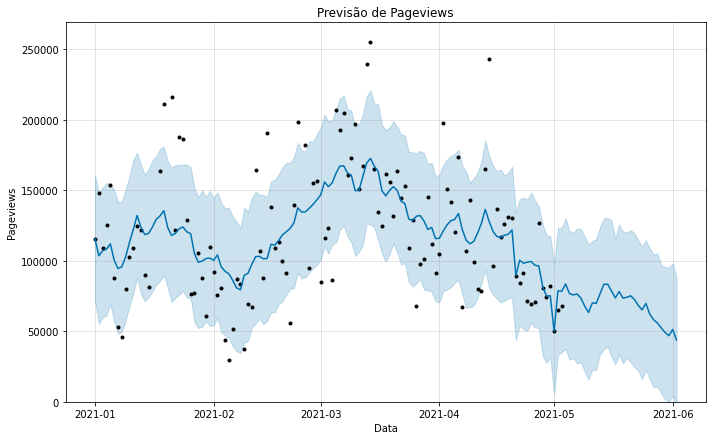

In [33]:
# criação do modelo para previsão
modelo = Prophet(**best_params)

# adição de uma sazonalidade mensal
modelo.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)

# adição de uma sazonalidade anual
modelo.add_seasonality(name = 'yearly', period = 365, fourier_order = 10)

# adição de feriados
modelo.add_country_holidays(country_name = 'BR')

# ajuste do modelo
modelo.fit(df_tratado_prev)

# criação de um df com as datas a serem previstas
futuro = modelo.make_future_dataframe(periods = 30)

# previsão para cada data em futuro
previsao = modelo.predict(futuro)

# visualização da previsão
modelo.plot(previsao)
plt.title("Previsão de Pageviews")
plt.xlabel("Data")
plt.ylabel("Pageviews")
plt.ylim(0, 269000)
plt.show()

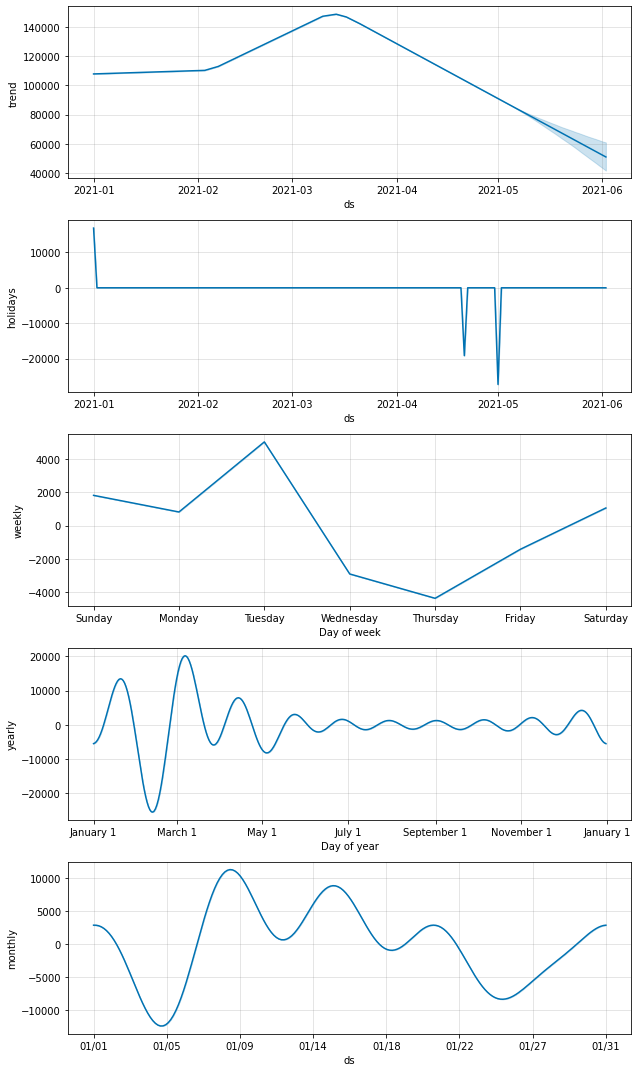

In [34]:
# visualização dos componentes da previsão
modelo.plot_components(previsao);

# 6. Conclusão

Após a limpeza e tratamento dos dados, foi realizada a análise do dataset. Nessa análise, foi possível perceber uma tendência de queda na audiência. Para entender a causa dessa queda, foi observada a relação dos pageviews com as outras variáveis. Foi concluído que a queda de visualizações na editoria_01 foi a principal causa da diminuição do total de pageviews.

Após a análise, foi realizada uma previsão da audiência para os próximos 30 dias. A previsão confirmou a ideia de tendência de queda e revelou que o número de pageviews tende a continuar caindo. Isso é demonstrado no gráfico *trend* dos componentes da previsão. Uma curiosidade foi que a audiência teve um pico no feriado do ano novo, mas uma queda nos outros feriados.